オリジナルの作成: 2011/06/05

<html id="* 第5章-多層パーセプトロン関数近似をSageで試す">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>第5章-多層パーセプトロン関数近似をSageで試す</h1>
	<p>
		PRMLの5章多層パーセプトロンを使った関数近似の例題、図5.3(PRMLから引用)をSageを使って試してみます。

		<table style="border-style: none;">
			<tr style="border-style: none;">
				<td style="border-style: none;"><img src="images/05/Figure5.3a.png" width="200"></td>
				<td style="border-style: none;"><img src="images/05/Figure5.3b.png" width="200"></td>
			</tr>
			<tr style="border-style: none;">
				<td style="border-style: none;"><img src="images/05/Figure5.3c.png" width="200"></td>
				<td style="border-style: none;"><img src="images/05/Figure5.3d.png" width="200"></td>
			</tr>
		</table>
				
	</p>	
</html>

<html id="** 計算条件">
	<h2>計算条件</h2>
	<p>
		関数近似に使用するニューラルネットワーク（多層パーセプトロン）は、
		<ul>
			<li>入力ユニット数1個（バイアス項を除く）</li>
			<li>隠れ層ユニット3個（バイアス項を除く）</li>
			<li>出力ユニット1個</li>
		</ul>
		としました。
	</p>
	<p>
		重みwの更新には、逐次的勾配降下法を使用し、学習回数は2000、学習率（η）を0.1としました。
		逐次的勾配降下法による学習は、収束が遅く、学習率の値はデータに依存します。
		また、重みwの初期値が結果に強く影響を与えることも分かりました。
	</p>
</html>

In [1]:
# ニューラルネットワーク（逐次勾配降下法による学習）
# PRML fig. 5.3を再現
# 
from pylab import linspace
# 定数をセット
N = 50
M = 4
LEARN_COUNT=2000
eta = 0.1
# 学習回数

In [2]:
# 入力1点、隠れ層3個、出力1点
N_in = 1   
N_h = M      
N_out = 1
# 隠れ層の活性化関数
h_1(x) = tanh(x)
# 出力層の活性化関数
h_2(x) = x
# 隠れ層の活性化関数の微分
dif_h_1(x) = diff(h_1, x)

<html id="** ニューラルネットワーク">
	<h2>ニューラルネットワーク</h2>
	<p>
		ニューラルネットワークでは、
		<ul>
			<li>フィードフォワード処理</li>
			<li>バックプロパゲート処理</li>
		</ul>
		を繰り返しながら重みwを更新し、関数を近似します。
	</p>
	<p>
		フィードフォワード処理では、隠れ層の活性$a_j$は
$$
		a_j = \sum_{i=1}^{D} w_{ji}^{(1)} + w_{j0}^{(1)}
$$	
		で計算され、活性化関数h{.}で変換され
$$
		z_j = h_1(a_j)
$$
		となります。	
		同様に、出力ユニットの活性は、
$$
		a_k = \sum_{j=1}^{M} w_{kj}^{(2)} + w_{k0}^{(2)}
$$
		となり、出力ユニット活性化関数h2{.}で変換さ
$$
		y_k = h_2(a_k)
$$
		となります。
	</p>
	<p>
		入力パターンnに対する誤差を、式(5.44)
$$
		E_n = \frac{1}{2} \sum_{k} (y_nk - t_nk)^2
$$
		を最小にするように重みwの偏微分は、式(5.50)
$$
		\frac{\partial E_n}{\partial w_{ji}} = \frac{\partial E_n}{\partial a_j} \frac{\partial a_j}{\partial w_{ji}}
$$
		は、誤差$\delta$を使って式(5.51)
$$
		\delta_j \equiv \frac{\partial E_n}{\partial a_j}
$$
		とすると、式(5.53)の変数をzからxに変更して、
$$
		\frac{\partial E_n}{\partial w_{ji}} = \delta_j x_i
$$	
		出力ユニットの誤差、式(5.54)
$$
		\delta_k = y_k - t_k
$$	
		から、式(5.55)
$$
		\delta_j \equiv \frac{\partial E_n}{\partial a_j} = \sum_{k} \frac{\partial E_n}{\partial a_k} \frac{\partial a_k}{\partial a_j}
$$
		となり、式(5.56)
$$
		\delta_j = h_1' (a_j) \sum_{k} w_{kj} \delta_k
$$
		という逆伝搬（バックプロパゲート処理）で求められます。
	</p>
	<p>
		重みの更新は、
$$
		w^{(\tau+1)} = w^{(\tau)} - \eta \nabla E_n(w^{(\tau)})
$$
		となります。
	</p>
	<p>
		sageのベクトル計算を使うことで、フィードフォワード処理、バックプロパゲート処理がほぼ上記の式の通りに
		記述することができます。
	</p>
</html>

In [3]:
# 逐次勾配降下法を使ったニューラルネットワークの定義
def _learn_sg(X, T, w_1, w_2, N_in, N_h, N_out, LEARN_COUNT):
    # 作業用ベクトルの定義
    x_i = vector(RDF, N_in+1); y_k = vector(RDF, N_out)
    z_j = vector(RDF, N_h); z_j[0] = 1
    d_j = vector(RDF, N_h); d_k = vector(RDF, N_out)    
    
    # 指定回数学習する
    for m in range(LEARN_COUNT):
        for n in range(len(X)):
            # 変数のセット
            x_i = vector(RDF, flatten([1, X[n]]))
            t = vector(RDF, flatten([T[n]]))
            # フィードフォワード処理
            for j in range(1, N_h):           
                z_j[j] = h_1(w_1.row(j)*x_i).n()
            for k in range(N_out):
                y_k[k] = h_2(w_2.row(k)*z_j).n()
            # バックプロパゲート処理
            d_k = y_k - t
            for j in range(N_h):
                d_j[j] = dif_h_1(z_j[j])*w_2.column(j)*d_k
            # 重みの更新
            for j in range(N_h):
                w_1.set_row(j, w_1[j] - eta*d_j[j]*x_i)
            for k in range(N_out):
                w_2.set_row(k, w_2[k] - eta*d_k[k]*z_j)

<html id="** 関数定義">
	<h2>関数定義</h2>
	<p>
		出力関数は、フィードフォワード処理で指定されたｘの値を計算します。
	</p>
	<p>
		プロット関数では、重み$w^{(1)}$をw_1、$w^{(2)}$をw_2を初期化（-1から1の一様分布）
		し、与えられた観測データにフィットする重みを計算し、その結果をプロットします。
	</p>
</html>

In [4]:
# 出力関数の定義
def _f(x, w_1, w_2, N_in, N_h, N_out):
    x_i = vector(RDF, flatten([1, x]))
    z_j = vector(RDF, N_h); z_j[0] = 1
    y_k = vector(RDF, N_out)
    # 隠れ層の値を計算
    for j in range(1, N_h):
        z_j[j] = h_1(w_1.row(j)*x_i).n()
    # 出力層の計算
    for k in range(N_out):
        y_k[k] = h_2(w_2.row(k)*z_j)
    return y_k[0]

<html id="** 計算結果">
	<h2>計算結果</h2>
	<p>
		以下の関数
		<ul>
			<li>ヘヴィサイドステップ関数</li>
			<li>$f(x) = |x|$</li>
			<li>$f(x) = sin(3/4*pi*x)$</li>
			<li>$f(x) = x^2$</li>
		</ul>
		を近似した結果を以下に示します。
	</p>
	<p>
		ニューラルネットワークのような単純なアルゴリズムでも良く近似できるものだと関心しました。
	</p>
</html>

In [5]:
def _plot_nn(X, T, N_in, N_h, N_out, COUNT):
    # 重みの初期化(バイアス項を含む)
    w_1 = matrix(RDF, [[(random()-0.5)*2 for i in range(N_in+1)] for j in range(N_h)])
    w_2 = matrix(RDF, [[(random()-0.5)*2 for j in range(N_h)] for k in range(N_out)])
    # 学習
    _learn_sg(X, T, w_1, w_2, N_in, N_h, N_out, COUNT)
    # トレーニングデータのプロット
    data_plt = list_plot(zip(X, T))
    # 結果のプロット
    var('x')
    f_plt = plot(lambda x : _f(x, w_1, w_2, N_in, N_h, N_out), [x, -1, 1], color='red')
    (data_plt + f_plt).show(figsize=4)

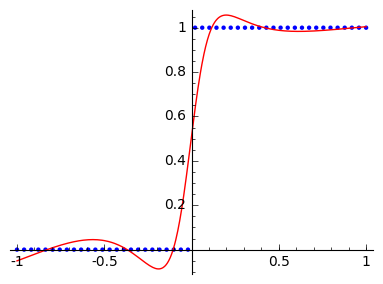

In [13]:
# トレーニングデータ
# 1番目は、heavisizeのステップ関数
X = linspace(-1, 1, N)
T = [heaviside(float(x)) for x in X]
# 計算とプロット
_plot_nn(X, T, N_in, N_h, N_out, LEARN_COUNT)

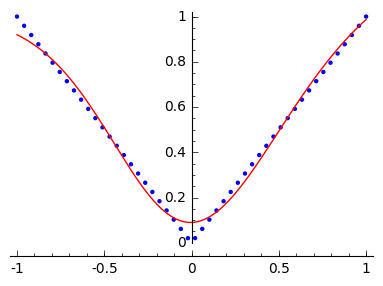

In [15]:
# 2番目は、絶対値
X = linspace(-1, 1, N)
T = [abs(x) for x in X]
# 計算とプロット
_plot_nn(X, T, N_in, N_h, N_out, LEARN_COUNT)

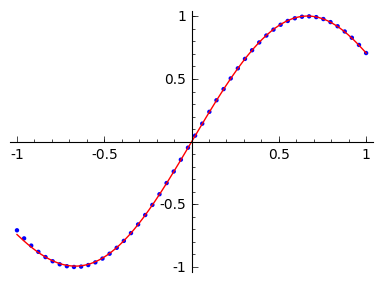

In [16]:
# 3番目は、sin(3/4πx)
X = linspace(-1, 1, N)
T = [sin(3/4*pi*x) for x in X]
# 計算とプロット
_plot_nn(X, T, N_in, N_h, N_out, LEARN_COUNT)

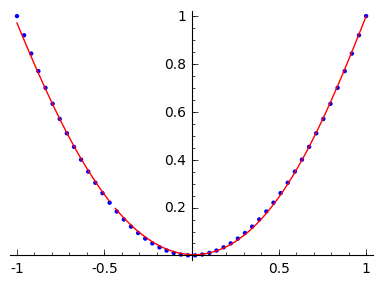

In [17]:
# 4番目は、2次曲線
X = linspace(-1, 1, N)
T = [x*x for x in X]
# 計算とプロット
_plot_nn(X, T, N_in, N_h, N_out, LEARN_COUNT)